In [44]:
!pip install meshio
!pip install gcsfs


  Using cached meshio-4.3.6-py3-none-any.whl (150 kB)


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr
#import meshio
#import gcsfs
#import hvplot.xarray

In [33]:
from IPython.display import HTML, display
import pandas as pd

- Access file system in google cloud storage 
- Get list of all time step files in there
- Set up mesh parameters and create xarray template based on that

In [120]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology')
filelist = fs.ls('ldeo-glaciology/elmer_janie/output_vals/')


#info about mesh grid (set by user in model)
xgrid_cells = 1000
ygrid_cells = 30

xgrid_pts = xgrid_cells + 1
ygrid_pts = ygrid_cells + 1

xnodes = np.array(range(xgrid_pts)) #ynodes 
ynodes = np.array(range(ygrid_pts))  # xnodes
tsteps = np.array(range(len(filelist)))  #number of time steps


In [124]:
timestep = [] #list of data arrays
for path in filelist:
    t_val = filelist.index(path)
    print(path)
    print(t_val)
    gcs_file = fs.get(path,'out.vtu') #load file
    mesh = meshio.read('out.vtu', file_format= 'vtu') #mesh the file
    
    velx = mesh.point_data['velocity'][:,0].reshape((ygrid_pts,xgrid_pts)) #reshape the mesh coordinates
    vely = mesh.point_data['velocity'][:,1].reshape((ygrid_pts,xgrid_pts))

    xdim = mesh.points[:,0].reshape((ygrid_pts,xgrid_pts))
    ydim = mesh.points[:,1].reshape((ygrid_pts,xgrid_pts))
    
    tempdataset = xr.Dataset(data_vars = {'vel_x' : (('ynode','xnode'), velx) ,'vel_y' :(('ynode','xnode'), vely)},
                      coords = {'yvals': (('ynode','xnode'),ydim),'xvals': (('ynode','xnode'),xdim)})
    timestep.append(tempdataset)

datacomb = xr.concat(timestep, dim='t')

ldeo-glaciology/elmer_janie/output_vals/Output0001.vtu
0
ldeo-glaciology/elmer_janie/output_vals/Output0002.vtu
1
ldeo-glaciology/elmer_janie/output_vals/Output0003.vtu
2
ldeo-glaciology/elmer_janie/output_vals/Output0004.vtu
3
ldeo-glaciology/elmer_janie/output_vals/Output0005.vtu
4
ldeo-glaciology/elmer_janie/output_vals/Output0006.vtu
5
ldeo-glaciology/elmer_janie/output_vals/Output0007.vtu
6
ldeo-glaciology/elmer_janie/output_vals/Output0008.vtu
7
ldeo-glaciology/elmer_janie/output_vals/Output0009.vtu
8
ldeo-glaciology/elmer_janie/output_vals/Output0010.vtu
9
ldeo-glaciology/elmer_janie/output_vals/Output0011.vtu
10
ldeo-glaciology/elmer_janie/output_vals/Output0012.vtu
11
ldeo-glaciology/elmer_janie/output_vals/Output0013.vtu
12
ldeo-glaciology/elmer_janie/output_vals/Output0014.vtu
13
ldeo-glaciology/elmer_janie/output_vals/Output0015.vtu
14
ldeo-glaciology/elmer_janie/output_vals/Output0016.vtu
15
ldeo-glaciology/elmer_janie/output_vals/Output0017.vtu
16
ldeo-glaciology/elmer_ja

In [1]:
datacomb.to_netcdf('full_run.nc')

NameError: name 'datacomb' is not defined

In [57]:
datacomb = xr.open_dataset('full_run.nc')
datacomb = datacomb.assign_coords(years = (datacomb.t * 10))
datacomb

<xarray.Dataset>
Dimensions:  (t: 120, xnode: 1001, ynode: 31)
Coordinates:
    yvals    (t, ynode, xnode) float64 ...
    xvals    (t, ynode, xnode) float64 ...
    years    (t) int64 0 10 20 30 40 50 60 ... 1140 1150 1160 1170 1180 1190
Dimensions without coordinates: t, xnode, ynode
Data variables:
    vel_x    (t, ynode, xnode) float64 ...
    vel_y    (t, ynode, xnode) float64 ...

ValueError: Only 1d and 2d plots are supported for facets in xarray. See the package `Seaborn` for more options.

<Figure size 864x576 with 0 Axes>

###  Surface level analysis for one time step 

In [58]:
surface = datacomb.yvals.sel(ynode = (datacomb.ynode.shape[0] - 1))
surface
(datacomb.ynode.shape[0] - 1)

30

In [10]:
(surface.xvals[0,1] - surface.xvals[0,0]).item()

20.0

In [59]:
dt = (surface.xvals[0,1] - surface.xvals[0,0]).item()
dysurf = np.zeros(surface.shape)
dy2surf = np.zeros(surface.shape)
for w in range(len(surface.t)):
    dysurf[w,1:] = (surface.sel(t = w)[1:] - surface.sel(t = w)[0:-1])/dt
    dy2surf[w,1:-1] = (surface.sel(t = w)[0:-2] - 2*surface.sel(t = w)[1:-1] + surface.sel(t = w)[2:])/(dt**2)




In [60]:
der = xr.Dataset(data_vars = {'dy' : (('t','xnode'), dysurf), 
                             'dy2' : (('t','xnode'), dy2surf)})
surfder = xr.merge([surface.drop('yvals'),der])
surfder.to_netcdf('surfder.nc')
#surfder.assign_coords(xvals = surfder.xvals)

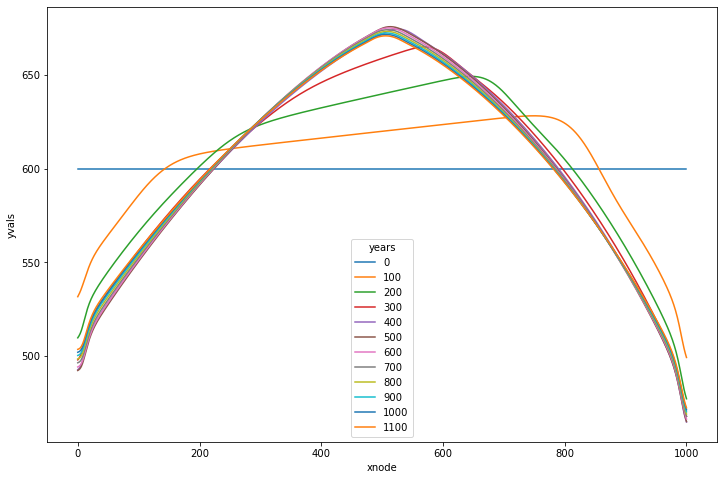

In [9]:
plt.figure(figsize = [12,8])
surface.sel(t= np.arange(0,120,10)).yvals.plot(hue='years');


Narrower part of the surface for analysis of the behaviour around the peak

In [19]:
surf_narrow = surfder.sel(xnode = slice(100,901))

surf_narrow

<xarray.Dataset>
Dimensions:  (t: 120, xnode: 801)
Coordinates:
    xvals    (t, xnode) float64 ...
    years    (t) int64 0 10 20 30 40 50 60 ... 1140 1150 1160 1170 1180 1190
Dimensions without coordinates: t, xnode
Data variables:
    yvals    (t, xnode) float64 ...
    dy       (t, xnode) float64 0.0 0.0 0.0 0.0 ... -0.02524 -0.0253 -0.02536
    dy2      (t, xnode) float64 0.0 0.0 0.0 ... -3.034e-06 -3.042e-06 -3.05e-06

In [43]:
#peakinds = {}
#indlinds = {}
#concinds = {}
peakinds = {'t':'peaks} 
inflinds = {'t':'infl'}
concinds = {'t':'conc'}
for k in range(10,surf_narrow.t.shape[0]):
    singleslice = surf_narrow.sel(t = k)
    peakind = 0
    inflind = []
    L = singleslice.dy2.shape[0]

    for i in range(L-1):
        if singleslice.dy[i]*singleslice.dy[i+1] < 0:
            peakind = i
        if singleslice.dy2[i]*singleslice.dy2[i+1] < 0:
            inflind.append(i)
    c_l = singleslice.dy2[0:peakind].argmax().item()
    c_r = singleslice.dy2[peakind:].argmax().item() + peakind
    peakinds[k] = peakind
    inflinds[k] = inflind
    concinds[k] = [c_l,c_r]

In [53]:

#pd = {"dims":'t', "data": }

TypeError: unhashable type: 'slice'

In [31]:
T = surf_narrow.t.shape[0]
#peakinds = np.zeros((T,1))
#inflinds = np.zeros((T,4))
#concinds = np.zeros((T,2))
peakarr = []
inflarr = []
concarr = [] 
for k in range(10,surf_narrow.t.shape[0]):
#for k in range(1,14):
    print(k)
    singleslice = surf_narrow.sel(t = k)
    peakind = 0
    inflind = []
    L = singleslice.dy2.shape[0]

    for i in range(L-1):
        #if singleslice.dy[i]*singleslice.dy[i+1] < 0:
        #    peakind = i
        if singleslice.dy2[i]*singleslice.dy2[i+1] < 0:
            inflind.append(i)
    #c_l = singleslice.dy2[0:peakind].argmax()
    #c_r = singleslice.dy2[peakind:].argmax() + peakind
    
    
    #peakarr.append(datacomb.sel(t = k, xnode = peakind))
    
    #variable number of inflection points (max 4)
    inflset = datacomb.sel(t = k, xnode = inflind)
    l = 4 - len(inflind)
    print(l)
    if l > 0:
        #print('{} infl points'.format(l))
        fill = xr.full_like(inflset.sel(xnode = slice(0,l)),np.nan)
        #print(fill.xnode.shape)
        inflsetfil = xr.concat([inflset,fill],dim = 'xnode')
        inflarr.append(inflsetfil)
    else:
        print('we good')
        inflarr.append(inflset)
    print(inflarr[-1].xnode.shape)
    #concarr.append(datacomb.sel(t = k, xnode = [c_l,c_r]))
   

10
3
(2,)
11
2
(4,)
12
2
(4,)
13
2
(4,)
14
2
(4,)
15
2
(4,)
16
2
(4,)
17
2
(4,)
18
2
(4,)
19
2
(4,)
20
2
(4,)
21
2
(4,)
22
2
(4,)
23
2
(4,)
24
2
(4,)
25
2
(4,)
26
2
(4,)
27
2
(4,)
28
2
(4,)
29
2
(4,)
30
2
(4,)
31
2
(4,)
32
2
(4,)
33
2
(4,)
34
2
(4,)
35
2
(4,)
36
2
(4,)
37
2
(4,)
38
2
(4,)
39
2
(4,)
40
2
(4,)
41
2
(4,)
42
2
(4,)
43
2
(4,)
44
2
(4,)
45
2
(4,)
46
2
(4,)
47
2
(4,)
48
2
(4,)
49
2
(4,)
50
2
(4,)
51
2
(4,)
52
2
(4,)
53
2
(4,)
54
2
(4,)
55
2
(4,)
56
2
(4,)
57
2
(4,)
58
2
(4,)
59
0
we good
(4,)
60
0
we good
(4,)
61
0
we good
(4,)
62
0
we good
(4,)
63
0
we good
(4,)
64
0
we good
(4,)
65
0
we good
(4,)
66
0
we good
(4,)
67
0
we good
(4,)
68
0
we good
(4,)
69
0
we good
(4,)
70
0
we good
(4,)
71
0
we good
(4,)
72
0
we good
(4,)
73
0
we good
(4,)
74
0
we good
(4,)
75
0
we good
(4,)
76
0
we good
(4,)
77
0
we good
(4,)
78
0
we good
(4,)
79
0
we good
(4,)
80
0
we good
(4,)
81
0
we good
(4,)
82
0
we good
(4,)
83
0
we good
(4,)
84
0
we good
(4,)
85
0
we good
(4,)
86
0
we good
(4,)
87
0
w

In [35]:
peakdat = xr.concat(peakarr, dim='t')
peakdat
peakdat.to_netcdf('peak_vals.nc')

ValueError: must supply at least one object to concatenate

In [26]:
concdat = xr.concat(concarr, dim='t')
peakdat
concdat.to_netcdf('conc_vals.nc')

In [33]:
infldat = xr.concat(inflarr[1:],dim='t')
infldat
infldat.to_netcdf('infl_vals.nc')

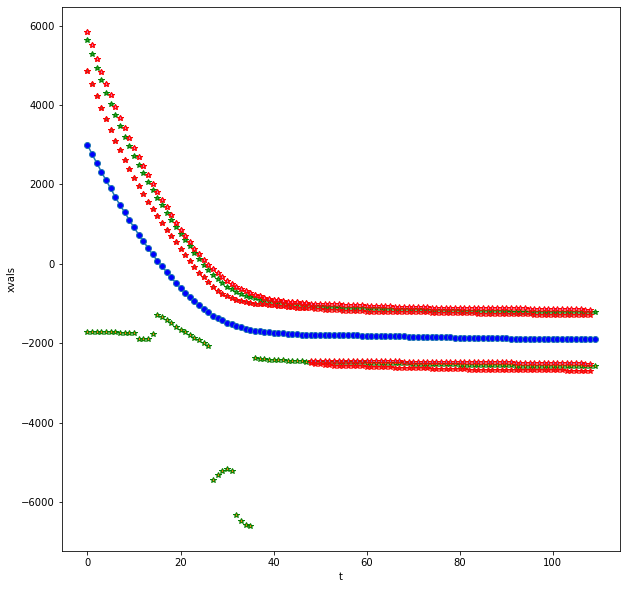

In [52]:
peakdat = xr.open_dataset('peak_vals.nc')
concdat = xr.open_dataset('conc_vals.nc')
infldat = xr.open_dataset('infl_vals.nc')

fig,ax = plt.subplots(figsize = [10,10])
peakdat.sel(ynode = (peakdat.ynode.shape[0] - 1)).xvals.plot(marker = 'o', markerfacecolor = 'blue', ax = ax, label ='Peak Value')

gsc = concdat.sel(ynode = (concdat.ynode.shape[0] - 1)).groupby('xnode')

for gname, gp in gsc:
    gp.xvals.plot(marker = '*',linestyle='None',markeredgecolor = 'green', ax = ax)

gsi = infldat.sel(ynode = (concdat.ynode.shape[0] - 1)).groupby('xnode')
for gname, gp in gsi:
    gp.xvals.plot(marker = '*',linestyle='None',markeredgecolor = 'red', ax = ax)



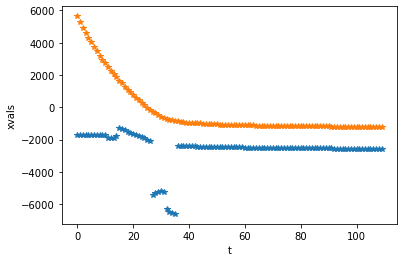

In [49]:
gs = concdat.sel(ynode = (concdat.ynode.shape[0] - 1)).groupby('xnode')

for gname, gp in gs:
    gp.xvals.plot(marker = '*',linestyle='None')

In [55]:
concdat

<xarray.Dataset>
Dimensions:  (t: 110, xnode: 2, ynode: 31)
Coordinates:
    yvals    (t, ynode, xnode) float64 ...
    xvals    (t, ynode, xnode) float64 ...
    years    (t) int64 ...
Dimensions without coordinates: t, xnode, ynode
Data variables:
    vel_x    (t, ynode, xnode) float64 ...
    vel_y    (t, ynode, xnode) float64 ...

(array([  64.,   27.,   92.,   32., 1404.,  467., 1932., 1062., 1659.,
          81.]),
 array([-1.91999782, -1.69371061, -1.46742339, -1.24113618, -1.01484897,
        -0.78856176, -0.56227455, -0.33598734, -0.10970013,  0.11658709,
         0.3428743 ]),
 <BarContainer object of 10 artists>)

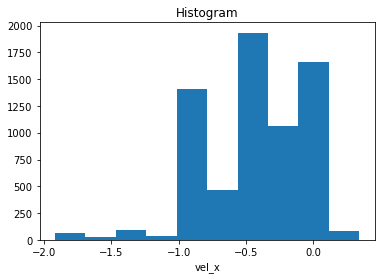

In [54]:
concdat.vel_x.plot()

In [64]:
singleslice = surf_narrow.sel(t = 100)

singleslice2 = surf_narrow.sel(t = 105)

singleslice.attrs['peakind'] = 80
singleslice2.attrs['peakind'] = 90

test = xr.merge([singleslice, singleslice2])
test

MergeError: conflicting values for variable 'years' on objects to be combined. You can skip this check by specifying compat='override'.

In [44]:
singleslice = surf_narrow.sel(t = 100)
peakind = 0
inflind = []
L = singleslice.dy2.shape[0]

for i in range(L-1):
    if singleslice.dy[i]*singleslice.dy[i+1] < 0:
        peakind = i
    if singleslice.dy2[i]*singleslice.dy2[i+1] < 0:
        inflind.append(i)


In [54]:
L = singleslice.dy2.shape[0]//2

#values of maximum concavity on either side of peak (currently L - middle...will change)
c_l = singleslice.dy2[0:peakind].argmax()
c_r = singleslice.dy2[peakind:].argmax() + peakind

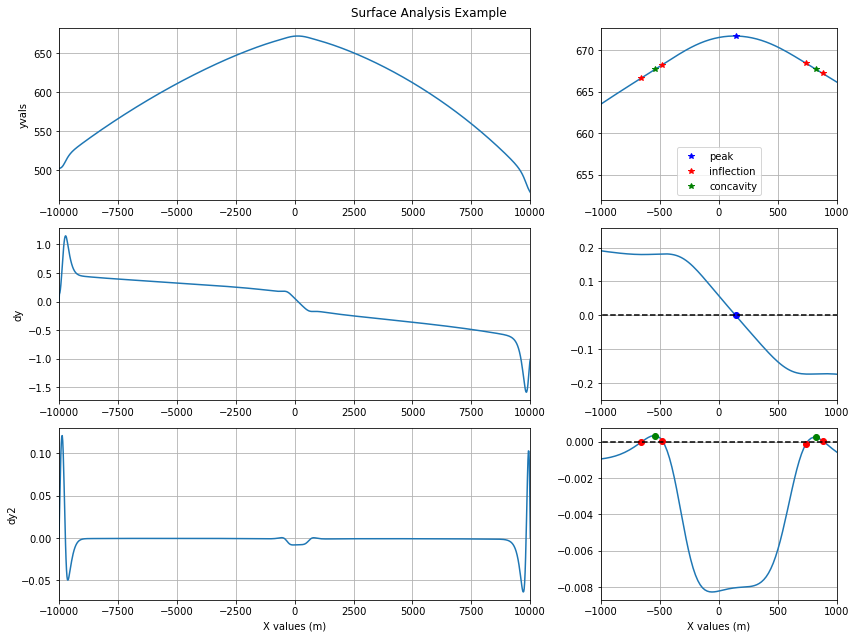

In [71]:
fig, ax = plt.subplots(ncols = 2,nrows = 3, figsize = [12,9],gridspec_kw={'width_ratios': [2, 1]})
surfder.yvals.sel(t = 100).plot(ax = ax[0,0],x = 'xvals')
surfder.dy.sel(t = 100).plot(ax = ax[1,0],x = 'xvals')
surfder.dy2.sel(t = 100).plot(ax = ax[2,0],x = 'xvals')
for x in range(3):
    ax[x,0].set_xlim([-10000,10000])
    ax[x,0].set_xlabel('')
    ax[x,0].grid()
#ax[0,0].set_title('Surface Analysis Example')
ax[2,0].set_xlabel('X values (m)')

singleslice.yvals.plot(ax = ax[0,1],x= 'xvals')
ax[0,1].plot(singleslice.xvals[peakind],singleslice.yvals[peakind], 'b*',label = 'peak')
ax[0,1].plot(singleslice.xvals[inflind],singleslice.yvals[inflind], 'r*', label = 'inflection')
ax[0,1].plot(singleslice.xvals[[c_l,c_r]],singleslice.yvals[[c_l,c_r]], 'g*', label = 'concavity')

singleslice.dy.plot(ax = ax[1,1],x= 'xvals')
ax[1,1].plot(singleslice.xvals[peakind],singleslice.dy[peakind], 'bo')
ax[1,1].plot([-2000,2000],[0,0], 'k--')

singleslice.dy2.plot(ax = ax[2,1],x= 'xvals')
ax[2,1].plot(singleslice.xvals[inflind],singleslice.dy2[inflind], 'ro')
ax[2,1].plot(singleslice.xvals[[c_l,c_r]],singleslice.dy2[[c_l,c_r]], 'go')
ax[2,1].plot([-2000,2000],[0,0], 'k--')

for x in range(3):
    ax[x,1].set_xlim([-1000,1000])
    ax[x,1].set_xlabel('')
    ax[x,1].set_ylabel('')
    
    ax[x,1].grid()
ax[2,1].set_xlabel('X values (m)')
ax[0,1].legend(loc = 'lower center')
fig.suptitle('Surface Analysis Example')
plt.tight_layout()
    #ax[x].set_xticks = surfder.xvals.sel(t=100)

In [98]:
surfder.xvals.sel(t=100)

<xarray.DataArray 'xvals' (xnode: 1001)>
array([-10000.,  -9980.,  -9960., ...,   9960.,   9980.,  10000.])
Dimensions without coordinates: xnode

#### Velocity Plots over time

In [15]:
##cut off boundary effects
data_nb = datacomb.sel(xnode = slice(200,801))
data_nb

<xarray.Dataset>
Dimensions:  (t: 120, xnode: 601, ynode: 31)
Coordinates:
    yvals    (t, ynode, xnode) float64 ...
    xvals    (t, ynode, xnode) float64 ...
    years    (t) int64 0 10 20 30 40 50 60 ... 1140 1150 1160 1170 1180 1190
Dimensions without coordinates: t, xnode, ynode
Data variables:
    vel_x    (t, ynode, xnode) float64 ...
    vel_y    (t, ynode, xnode) float64 ...

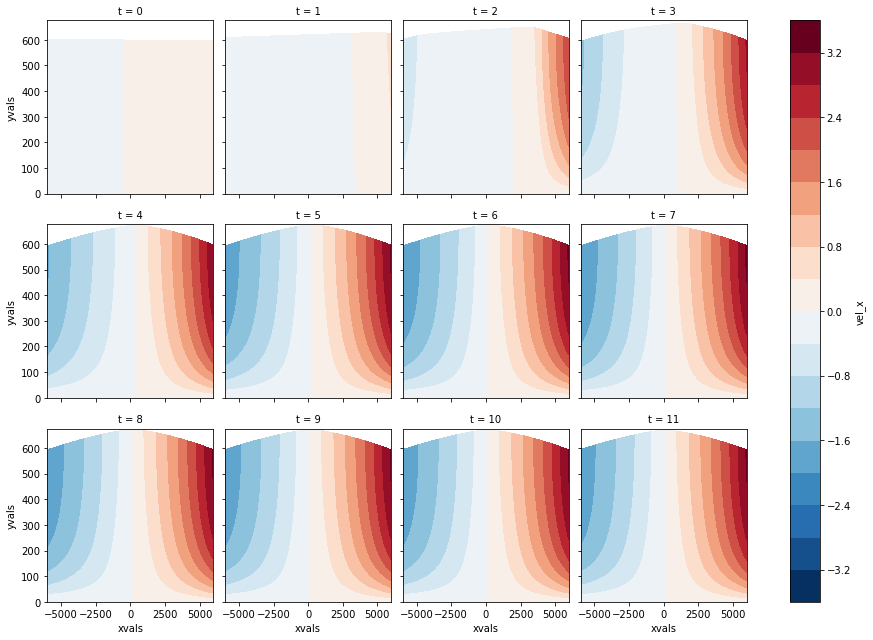

In [24]:
data_nb.sel(t = np.arange(0,120,10)).vel_x.plot.contourf(x = 'xvals', y = 'yvals',
    col = 't', col_wrap = 4, levels = 20
)

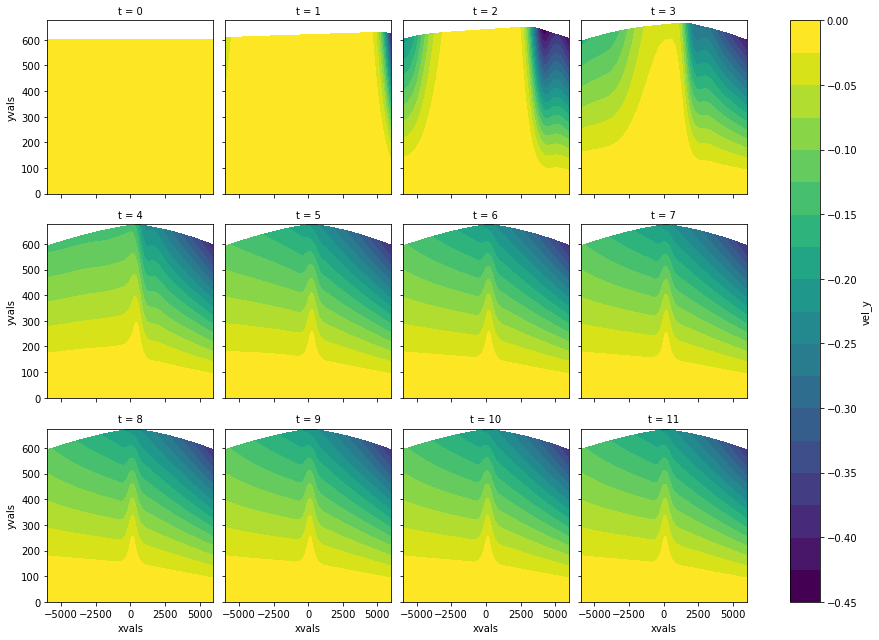

In [25]:
data_nb.sel(t = np.arange(0,120,10)).vel_y.plot.contourf(x = 'xvals', y = 'yvals',
    col = 't', col_wrap = 4, levels = 20
)

In [61]:
data_nb.sel(t = np.arange(0,120,10)).vel_y.hvplot.contourf(groupby = 'years',x = 'xvals', y = 'yvals'
)

KeyError: "Dimension 'years' not found."

In [ ]:
for i in range(25):
   
    with fs.open('ldeo-glaciology/elmer_janie/output_vals/Output0001.vtu', 'rb') as f:
        print('line {}'.format(i))
        print(f.readlines()[i].decode('utf-8'))

In [68]:
###doesnt work alas
for i in range (25,50):
    with fs.open('ldeo-glaciology/elmer_janie/output_vals/Output0001.vtu', 'rb', buffering = 0) as f:
        print(f.readlines()[i])
#f.readlines()[1]

b"_\xb8\xc9\x03\x00\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0\x82@\x00\x00\x00\x00\x00\xc0

In [10]:
#! wget https://storage.googleapis.com/ldeo-glaciology/elmer_janie/output_vals/Output0100.vtu


--2020-11-24 15:43:58--  https://storage.googleapis.com/ldeo-glaciology/elmer_janie/output_vals/Output0100.vtu
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3485120 (3.3M) [application/octet-stream]
Saving to: ‘Output0100.vtu’

Output0100.vtu      100%[===================>]   3.32M  --.-KB/s    in 0.07s   

2020-11-24 15:43:58 (47.3 MB/s) - ‘Output0100.vtu’ saved [3485120/3485120]



In [162]:
#surfurl = 'gs://ldeo-glaciology/elmer_janie/output_vals/Output0001.vtu'

url_test = 'gcs://ldeo-glaciology/elmer_janie/output_vals/Output0001.vtu'

url = 'https://storage.googleapis.com/ldeo-glaciology/elmer_janie/output_vals/Output0100.vtu'


testf = fsspec.open(url_test, mode = 'rb',encoding='utf8')

u1=urllib.request.urlopen(url).results()
#mapper = fsspec.get_mapper(url_test)

AttributeError: 'HTTPResponse' object has no attribute 'results'

In [63]:
mesh = meshio.read('Output0100.vtu', file_format= 'vtu')

In [4]:
#info about mesh grid (set by user in model)
xgrid_cells = 1000
ygrid_cells = 30

xgrid_pts = xgrid_cells + 1
ygrid_pts = ygrid_cells + 1

xnodes = np.array(range(xgrid_pts))
ynodes = np.array(range(ygrid_pts))

In [65]:
ynodes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [36]:
mesh?

Type:        Mesh
String form:
<meshio mesh object>
  Number of points: 31031
  Number of cells:
    quad: 30000
    line: 2060
  Point data: depth, height, pressure, temperature, age, velocity
File:        /srv/conda/envs/notebook/lib/python3.7/site-packages/meshio/_mesh.py
Docstring:   <no docstring>


In [57]:
mesh.points[:,2]

array([0., 0., 0., ..., 0., 0., 0.])

In [52]:
coords = mesh.points

In [54]:
coords[:,0]

array([-10000.,  -9980.,  -9960., ...,   9960.,   9980.,  10000.])

In [12]:
mesh.point_data

{'depth': array([[501.74985829],
        [501.87925934],
        [502.03745095],
        ...,
        [  0.        ],
        [  0.        ],
        [  0.        ]]),
 'height': array([[  0.        ],
        [  0.        ],
        [  0.        ],
        ...,
        [473.19663875],
        [472.13815746],
        [471.12860036]]),
 'pressure': array([[3.8784842 ],
        [4.20502508],
        [4.54385694],
        ...,
        [0.0870551 ],
        [0.09161384],
        [0.0994165 ]]),
 'temperature': array([[257.73628843],
        [257.76482518],
        [257.82654591],
        ...,
        [253.15      ],
        [253.15      ],
        [253.15      ]]),
 'age': array([[1.14510290e+03],
        [3.37369546e+03],
        [2.34351971e+03],
        ...,
        [1.05469674e-01],
        [1.71703200e-01],
        [2.44591036e-01]]),
 'velocity': array([[-2.17420902,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.    

In [6]:
velx = mesh.point_data['velocity'][:,0].reshape((ygrid_pts,xgrid_pts))
vely = mesh.point_data['velocity'][:,1].reshape((ygrid_pts,xgrid_pts))

xdim = mesh.points[:,0].reshape((ygrid_pts,xgrid_pts))
ydim = mesh.points[:,1].reshape((ygrid_pts,xgrid_pts))

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


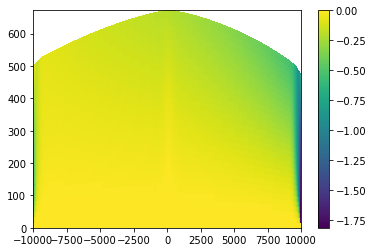

In [87]:
ggg = plt.pcolormesh(xdim,ydim, vely,shading = 'flat')
plt.colorbar(ggg)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The following kwargs were not used by contour: 'shading'
  """Entry point for launching an IPython kernel.


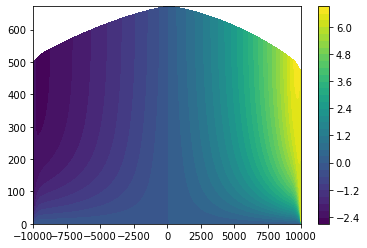

In [28]:
hhh = plt.contourf(xdim,ydim, velx,shading = 'flat',levels = 30)
plt.colorbar(hhh)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


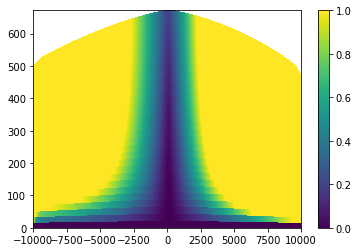

In [14]:
vel_mag = np.sqrt(velx**2 + vely**2)
iii = plt.pcolormesh(xdim,ydim, vel_mag,shading = 'flat',vmin = 0, vmax = 1)
plt.colorbar(iii)

In [19]:
data_attempt1 = xr.Dataset(data_vars = {'vel_x' : (('ynode','xnode'), velx) ,'vel_y' :(('ynode','xnode'), vely), 'yvals': (('ynode','xnode'),ydim),'xvals': (('ynode','xnode'),xdim)}, coords = {'xnode': xnodes, 'ynode': ynodes})

In [123]:
data = xr.Dataset(data_vars = {'vel_x' : (('ynode','xnode'), velx) ,'vel_y' :(('ynode','xnode'), vely)},
                      coords = {'yvals': (('ynode','xnode'),ydim),'xvals': (('ynode','xnode'),xdim)})

TypeError: __init__() got an unexpected keyword argument 'data_vars'

In [40]:
data

<xarray.Dataset>
Dimensions:  (xnode: 1001, ynode: 31)
Coordinates:
    yvals    (ynode, xnode) float64 0.0 0.0 0.0 0.0 ... 474.3 473.2 472.1 471.1
    xvals    (ynode, xnode) float64 -1e+04 -9.98e+03 ... 9.98e+03 1e+04
Dimensions without coordinates: xnode, ynode
Data variables:
    vel_x    (ynode, xnode) float64 -2.174 0.0 0.0 0.0 ... 6.327 6.257 6.175
    vel_y    (ynode, xnode) float64 0.0 0.0 0.0 0.0 ... -0.7179 -0.6901 -0.6792

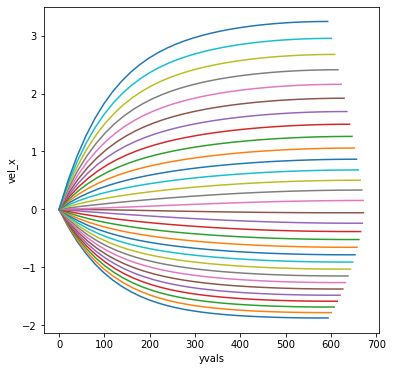

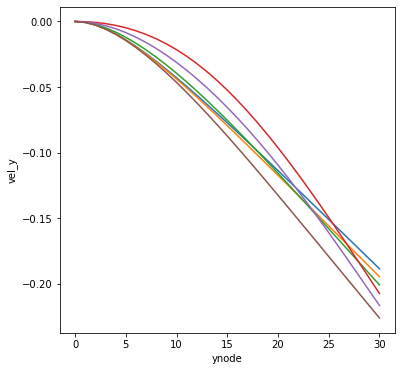

In [102]:
plt.figure(figsize = [6,6])

for i in range(200,801,20):
    data.vel_x.sel(xnode = i).plot(x = 'yvals')
plt.figure(figsize = [6,6]) 
for i in range(440,541,20):
    data.vel_y.sel(xnode = i).plot()

<xarray.Dataset>
Dimensions:  (xnode: 1, ynode: 29)
Coordinates:
    yvals    (ynode, xnode) float64 21.66 43.33 64.99 ... 585.0 606.7 628.3
    xvals    (ynode, xnode) float64 2.52e+03 2.52e+03 ... 2.52e+03 2.52e+03
Dimensions without coordinates: xnode, ynode
Data variables:
    vel_x    (ynode, xnode) float64 0.1529 0.2818 0.391 ... 1.113 1.116 1.118
    vel_y    (ynode, xnode) float64 -0.0009681 -0.003531 ... -0.2455 -0.2564

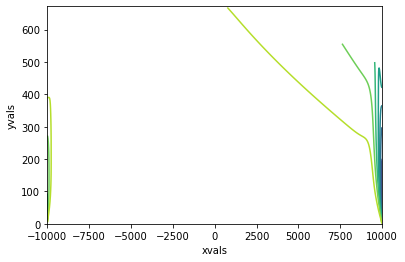

In [90]:
data.vel_y.plot.contour(x='xvals',y='yvals',levels = 10, vmax = 0)

The boundary effects are strongly affecting this. However! What we are interested in is a much smaller part of the model - need to slice off the boundary points. 

In [29]:
data_cent = data.sel(xnode = slice(400,601))

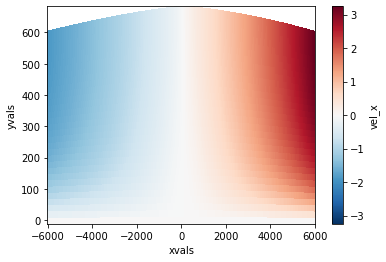

In [33]:
data_cent.vel_x.plot(x='xvals',y='yvals')

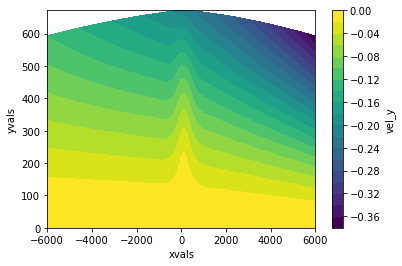

In [110]:
data_cent.vel_y.plot.contourf(x='xvals',y='yvals',levels = 20)

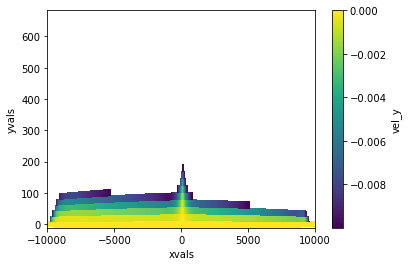

In [77]:
data.vel_y.where(data.vel_y > -1e-2).plot(x='xvals',y='yvals')

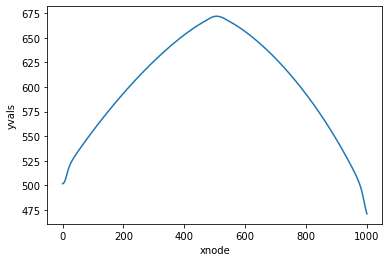

In [9]:
surf = data.yvals[-1] 
surf.plot()

In [10]:
dt = data.xnode[1] - data.xnode[0]
dy = np.zeros(surf.shape) # first derivative 
dy2 = np.zeros(surf.shape)
dy[1:] = (surf[1:] - surf[0:-1])/dt #finite difference 1st derivative
dy2[1:-1] = (surf[0:-2] - 2*surf[1:-1] + surf[2:])/(dt**2) #finite central difference 2nd derivative

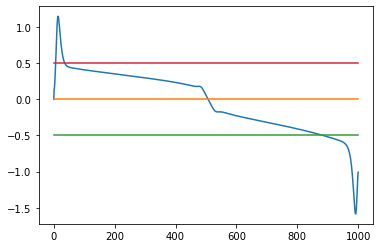

In [13]:
plt.plot(xnodes,dy)
plt.plot([0,1000],[0,0])
plt.plot([0,1000],[-0.5,-0.5])
plt.plot([0,1000],[0.5,0.5])

In [22]:
600/30

20.0

In [ ]:
np.